In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import spacy
import nltk

import json
import pandas as pd
import numpy as np
from datetime import datetime as dt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-shows/netflix_titles.csv


## Loading and transforming the data

In [74]:
path_for_csv = "/kaggle/input/netflix-shows/netflix_titles.csv"
try:
    df = pd.read_csv(path_for_csv, encoding='utf-8')
except:
    df = pd.read_csv(path_for_csv, encoding='latin1')

In [75]:
df.description=df.description.str.lower()

In [76]:
df.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [77]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"as her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","after crossing paths at a party, a cape town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",to protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",in a city of coaching centers known to train i...


In [78]:
df.iloc[0]

show_id                                                        s1
type                                                        Movie
title                                        Dick Johnson Is Dead
director                                          Kirsten Johnson
cast                                                          NaN
country                                             United States
date_added                                     September 25, 2021
release_year                                                 2020
rating                                                      PG-13
duration                                                   90 min
listed_in                                           Documentaries
description     as her father nears the end of his life, filmm...
Name: 0, dtype: object

In [79]:
df.dtypes

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

In [80]:
df['listed_in'].unique()

array(['Documentaries', 'International TV Shows, TV Dramas, TV Mysteries',
       'Crime TV Shows, International TV Shows, TV Action & Adventure',
       'Docuseries, Reality TV',
       'International TV Shows, Romantic TV Shows, TV Comedies',
       'TV Dramas, TV Horror, TV Mysteries', 'Children & Family Movies',
       'Dramas, Independent Movies, International Movies',
       'British TV Shows, Reality TV', 'Comedies, Dramas',
       'Crime TV Shows, Docuseries, International TV Shows',
       'Dramas, International Movies',
       'Children & Family Movies, Comedies',
       'British TV Shows, Crime TV Shows, Docuseries',
       'TV Comedies, TV Dramas', 'Documentaries, International Movies',
       'Crime TV Shows, Spanish-Language TV Shows, TV Dramas',
       'Thrillers',
       'International TV Shows, Spanish-Language TV Shows, TV Action & Adventure',
       'International TV Shows, TV Action & Adventure, TV Dramas',
       'Comedies, International Movies',
       'Comedies, 

In [81]:
df.keys()

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

## Constructing Test graph
Here we have manually added edges and nodes to represent a particular movie, in this case "*Dick Johnson Is Dead*"

In [82]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph() #or G = nx.MultiDiGraph()


G.add_edge('s1', 'Movie', relation = 'is_a')

G.add_edge('s1', 'Dick Johnson Is Dead', relation = 'title')

G.add_edge('s1', 'Kirsten Johnson', relation = 'director')

G.add_edge('s1', 'United States', relation = 'country')

G.add_edge('s1', 'September 25, 2021', relation = 'date_added')

G.add_edge('s1', 2020, relation = 'release_year')

G.add_edge('s1', 'PG-13', relation = 'rating')

G.add_edge('s1', '90', relation = 'duration_in_min')

G.add_edge('s1', 'Documentaries', relation = 'listed_in')

G.add_edge('s1', 'As her father nears the end of his life, filmm...', relation = 'description')

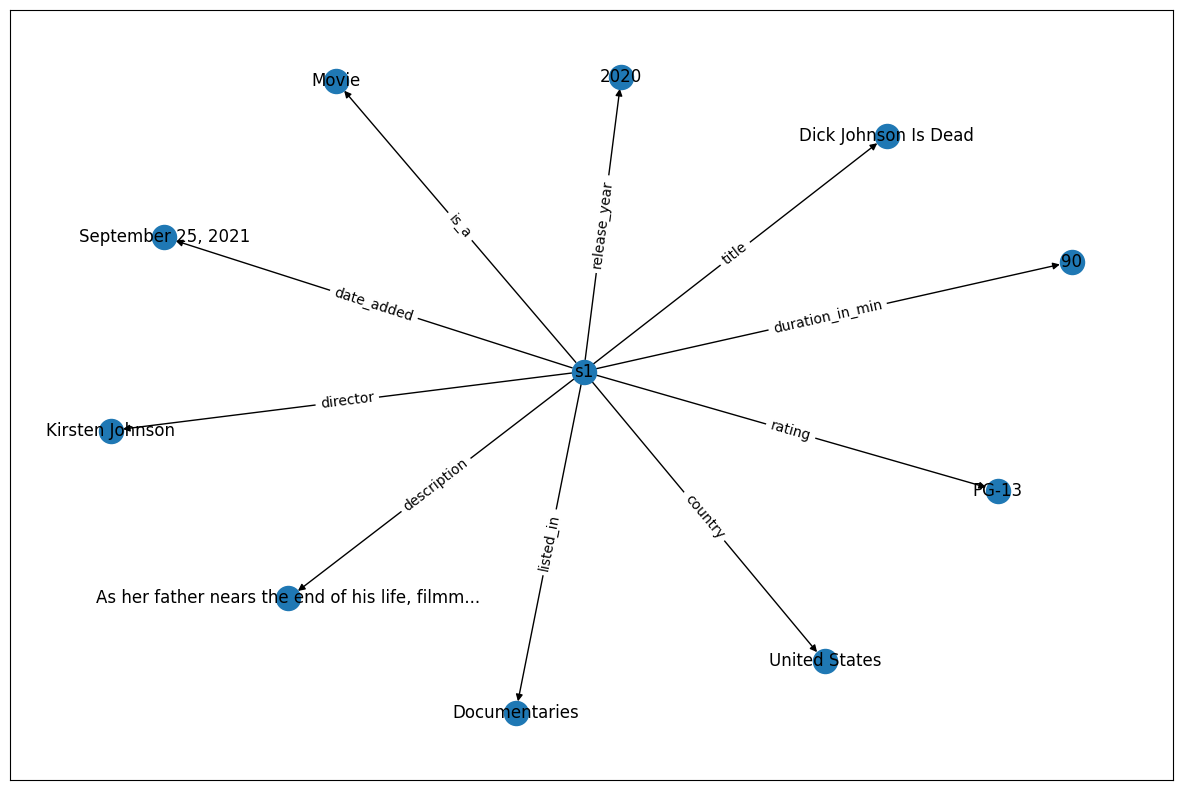

In [83]:
pos = nx.spring_layout(G)

_=nx.draw_networkx(G, pos)

edge_labels=dict([((u,v,),d['relation'])
             for u,v,d in G.edges(data=True)])

_=nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

## Testing Keywords extractor for the task on hand  
Here we will create a keyword extractor, for extracting keywords from the description provided for the movies. After connecting the movie with them, we can backtrack to see all the movies of the similar type and content 

In [84]:
import spacy
nlp = spacy.load("en_core_web_sm")
text = """spaCy is an open-source software library for advanced natural language processing, 
written in the programming languages Python and Cython. The library is published under the MIT license
and its main developers are Matthew Honnibal and Ines Montani, the founders of the software company Explosion."""
doc = nlp(text)
list_of_words=list(doc.ents)
for words in list_of_words:
    words=str(words)
    print(words.strip().split(" "))

['Python']
['Cython']
['MIT']
['Matthew', 'Honnibal']
['Ines', 'Montani']
['Explosion']


## Constructing whole graph

In [85]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph() #used for visualization, but we cant use it for community detection 
#G = nx.MultiDiGraph()

n = 10#df.count()[0]
#here n in the number of data  we are making the visual for, we can use n=1 for making a graph for only one data point 
df.keys()

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [86]:
for i in range(n):
  movie=df.iloc[i]
  #print(movie['title'])

  show_id= movie['show_id'] if not pd.isna(movie['show_id']) else ''
  type_of= movie['type'] if not pd.isna(movie['type']) else ''
  title = movie['title'] if not pd.isna(movie['title']) else ''
  director= movie['director'] if not pd.isna(movie['director']) else ''
  cast= movie['cast'] if not pd.isna(movie['cast']) else ''
  country = movie['country'] if not pd.isna(movie['country']) else ''
  date_added= movie['date_added'] if not pd.isna(movie['date_added']) else ''
  release_year= movie['release_year'] if not pd.isna(movie['release_year']) else ''
  rating = movie['rating'] if not pd.isna(movie['rating']) else ''
  duration= movie['duration'] if not pd.isna(movie['duration']) else ''
  cast = movie['cast'] if not pd.isna(movie['cast']) else ''
  listed_in = movie['listed_in'] if not pd.isna(movie['listed_in']) else ''
  description = movie['description'] if not pd.isna(movie['description']) else ''


  G.add_edge(show_id, type_of, relation = 'is_a')

  G.add_edge(show_id, title, relation = 'title')

  G.add_edge(show_id, director, relation = 'director')

  G.add_edge(show_id, country, relation = 'country')

  G.add_edge(show_id, date_added, relation = 'date_added')

  G.add_edge(show_id, release_year , relation = 'release_year')

  G.add_edge(show_id, rating, relation = 'rating')

  G.add_edge(show_id, duration, relation = 'duration')

  casts=cast.split(',')
  for cast in casts:
    G.add_edge(show_id, cast.strip(), relation = 'cast')

  listed_in=listed_in.split(',')
  for cat in listed_in:
    G.add_edge(show_id, cat.strip(), relation = 'listed_in')


  doc = nlp(text)
  list_of_words=[]
  for words in list(doc.ents):
    words=str(words)
    list_of_words.extend(words.strip().split(" "))  
    
    
  for keyword in list_of_words:
    G.add_node(keyword)
    G.add_edge(show_id, keyword.strip(), relation = 'description')
G.remove_node('')

Plotting the graph G 

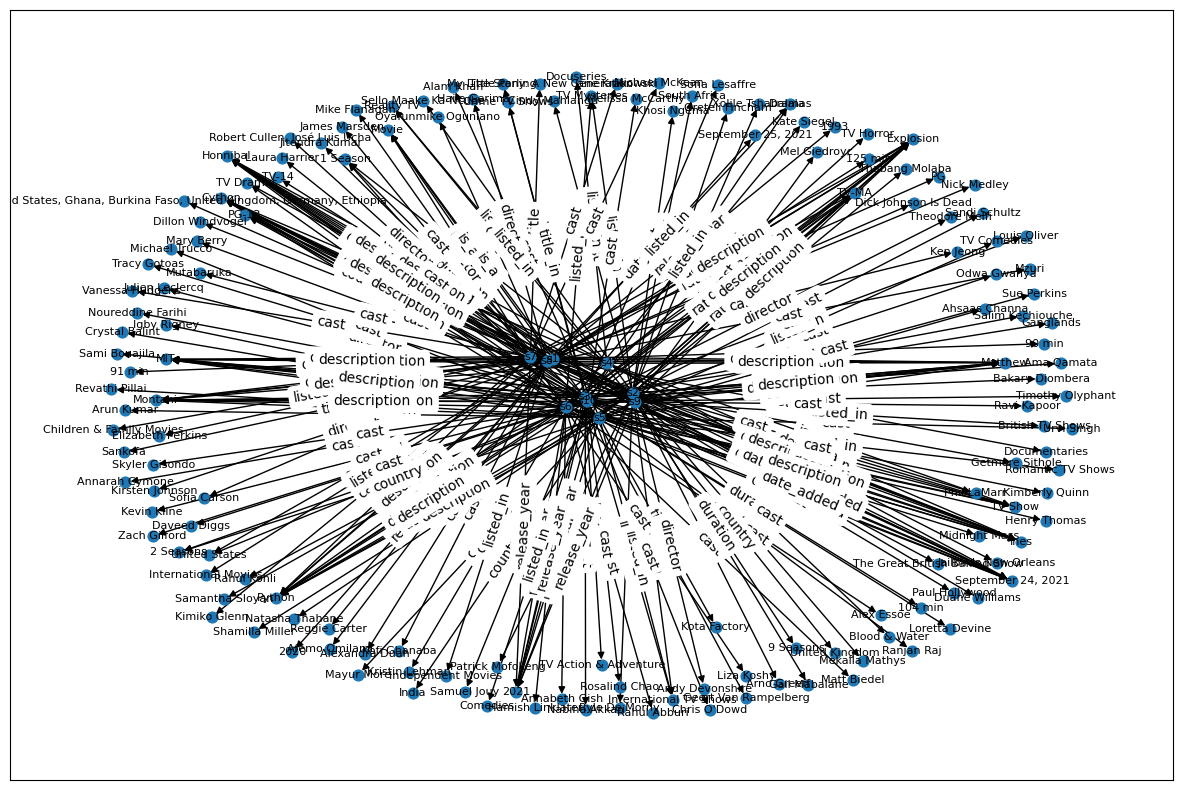

In [87]:
pos = nx.spring_layout(G)

_=nx.draw_networkx(G, pos,node_size=60,font_size=8) 
#nx.draw(G,pos,node_size=60,font_size=8) 

edge_labels=dict([((u,v,),d['relation'])
             for u,v,d in G.edges(data=True)])

#_=plt.figure(3,figsize=(12,12)) 

_=nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


In [88]:
G.edges(data=True)#extracting the data from edges,and it labels

OutEdgeDataView([('s1', 'Movie', {'relation': 'is_a'}), ('s1', 'Dick Johnson Is Dead', {'relation': 'title'}), ('s1', 'Kirsten Johnson', {'relation': 'director'}), ('s1', 'United States', {'relation': 'country'}), ('s1', 'September 25, 2021', {'relation': 'date_added'}), ('s1', 2020, {'relation': 'release_year'}), ('s1', 'PG-13', {'relation': 'rating'}), ('s1', '90 min', {'relation': 'duration'}), ('s1', 'Documentaries', {'relation': 'listed_in'}), ('s1', 'Python', {'relation': 'description'}), ('s1', 'Cython', {'relation': 'description'}), ('s1', 'MIT', {'relation': 'description'}), ('s1', 'Matthew', {'relation': 'description'}), ('s1', 'Honnibal', {'relation': 'description'}), ('s1', 'Ines', {'relation': 'description'}), ('s1', 'Montani', {'relation': 'description'}), ('s1', 'Explosion', {'relation': 'description'}), ('s2', 'TV Show', {'relation': 'is_a'}), ('s2', 'Blood & Water', {'relation': 'title'}), ('s2', 'South Africa', {'relation': 'country'}), ('s2', 'September 24, 2021', {'

In [89]:
G.nodes(data=True)#extracting the data from nodes,and it labels

NodeDataView({'s1': {}, 'Movie': {}, 'Dick Johnson Is Dead': {}, 'Kirsten Johnson': {}, 'United States': {}, 'September 25, 2021': {}, 2020: {}, 'PG-13': {}, '90 min': {}, 'Documentaries': {}, 'Python': {}, 'Cython': {}, 'MIT': {}, 'Matthew': {}, 'Honnibal': {}, 'Ines': {}, 'Montani': {}, 'Explosion': {}, 's2': {}, 'TV Show': {}, 'Blood & Water': {}, 'South Africa': {}, 'September 24, 2021': {}, 2021: {}, 'TV-MA': {}, '2 Seasons': {}, 'Ama Qamata': {}, 'Khosi Ngema': {}, 'Gail Mabalane': {}, 'Thabang Molaba': {}, 'Dillon Windvogel': {}, 'Natasha Thahane': {}, 'Arno Greeff': {}, 'Xolile Tshabalala': {}, 'Getmore Sithole': {}, 'Cindy Mahlangu': {}, 'Ryle De Morny': {}, 'Greteli Fincham': {}, 'Sello Maake Ka-Ncube': {}, 'Odwa Gwanya': {}, 'Mekaila Mathys': {}, 'Sandi Schultz': {}, 'Duane Williams': {}, 'Shamilla Miller': {}, 'Patrick Mofokeng': {}, 'International TV Shows': {}, 'TV Dramas': {}, 'TV Mysteries': {}, 's3': {}, 'Ganglands': {}, 'Julien Leclercq': {}, '1 Season': {}, 'Sami Bou

# Analyzing the above graph using NetworkX library 

## Which node is important?

#### **Degree centrality** 
It starts with the assumption that the person with the most connections (edges) is the most important. Rather than returning a count it is the degree of the node divided by the total possible number of edges that the node could have. For the case of the directed graph the degree of the incoming vertices and outgoing vertices would likely be treated separately.

Where N is the the graph and v is the vertex (node) that we are measuring.

$Centality_{degree}(v) = \frac{degree_{v}}{|N|-1}$

*   A Degree Centrality of 1 means the node is directly connected to every other node
*   A Degree Centrality of 0 means the node isn't connected to any other node in the network



In [90]:
degree_centrality=nx.degree_centrality(G)

dict(sorted(degree_centrality.items(), key=lambda item: item[1]))
# Here we are extracting degree_centrality for each node
# The degree centrality values are normalized by dividing by the maximum possible 
# degree in a simple graph n-1 where n is the number of nodes in G.

# For multigraphs or graphs with self loops the maximum degree might be higher 
# than n-1 and values of degree centrality greater than 1 are possible.

{'Dick Johnson Is Dead': 0.006289308176100629,
 'Kirsten Johnson': 0.006289308176100629,
 'September 25, 2021': 0.006289308176100629,
 2020: 0.006289308176100629,
 '90 min': 0.006289308176100629,
 'Documentaries': 0.006289308176100629,
 'Blood & Water': 0.006289308176100629,
 'South Africa': 0.006289308176100629,
 'Ama Qamata': 0.006289308176100629,
 'Khosi Ngema': 0.006289308176100629,
 'Gail Mabalane': 0.006289308176100629,
 'Thabang Molaba': 0.006289308176100629,
 'Dillon Windvogel': 0.006289308176100629,
 'Natasha Thahane': 0.006289308176100629,
 'Arno Greeff': 0.006289308176100629,
 'Xolile Tshabalala': 0.006289308176100629,
 'Getmore Sithole': 0.006289308176100629,
 'Cindy Mahlangu': 0.006289308176100629,
 'Ryle De Morny': 0.006289308176100629,
 'Greteli Fincham': 0.006289308176100629,
 'Sello Maake Ka-Ncube': 0.006289308176100629,
 'Odwa Gwanya': 0.006289308176100629,
 'Mekaila Mathys': 0.006289308176100629,
 'Sandi Schultz': 0.006289308176100629,
 'Duane Williams': 0.0062893081

#### **Closeness Centrality**
This measure assumes that the node that is closest to all the other nodes is the most important. It is the ratio of the highest possible degree for the node to the sum of the shortest paths to the other nodes. 

Where N is the the graph and v is the vertex (node) that we are measuring.

$Centality_{closeness}(v) = \frac{|N|-1}{sum\,of\,shortest\,path\,of\,v}$

In [91]:
closeness_centrality = nx.closeness_centrality(G)

dict(sorted(closeness_centrality.items(), key=lambda item: item[1]))

{'s1': 0.0,
 's2': 0.0,
 's3': 0.0,
 's4': 0.0,
 's5': 0.0,
 's6': 0.0,
 's7': 0.0,
 's8': 0.0,
 's9': 0.0,
 's10': 0.0,
 'Dick Johnson Is Dead': 0.006289308176100629,
 'Kirsten Johnson': 0.006289308176100629,
 'September 25, 2021': 0.006289308176100629,
 2020: 0.006289308176100629,
 '90 min': 0.006289308176100629,
 'Documentaries': 0.006289308176100629,
 'Blood & Water': 0.006289308176100629,
 'South Africa': 0.006289308176100629,
 'Ama Qamata': 0.006289308176100629,
 'Khosi Ngema': 0.006289308176100629,
 'Gail Mabalane': 0.006289308176100629,
 'Thabang Molaba': 0.006289308176100629,
 'Dillon Windvogel': 0.006289308176100629,
 'Natasha Thahane': 0.006289308176100629,
 'Arno Greeff': 0.006289308176100629,
 'Xolile Tshabalala': 0.006289308176100629,
 'Getmore Sithole': 0.006289308176100629,
 'Cindy Mahlangu': 0.006289308176100629,
 'Ryle De Morny': 0.006289308176100629,
 'Greteli Fincham': 0.006289308176100629,
 'Sello Maake Ka-Ncube': 0.006289308176100629,
 'Odwa Gwanya': 0.00628930817

#### **Betweeness Centrality**
Betweenness centrality of a node  is the sum of the fraction of all-pairs shortest paths that pass through. Betweenness Centrality of a node *v* is defined as —

$Centality_{betweeness}(v) = \sum_{s,t ∈ V}^{upper} \frac{σ(s,t|v)}{σ(s,t)}$

where V is the set of nodes σ(s,t), is the number of shortest (s,t) paths, and σ(s,t|v) is the number of those paths passing through some node v other than s,t . If s=t, σ(s,t)=1, and if v ∈ s,t,  σ(s,t|v)=0

This metric captures a different view of the importance of a node. Instead of finding nodes with more number of neighbors, it finds the bottleneck nodes in a network. We can find betweenness centrality of nodes of graph G using the nx.betweenness_centrlality(G) method. 

Thus, it represents the frequency at which a point occurs on the geodesic (shortest paths) that connected pair of points. It quantifies how many times a particular node comes in the shortest chosen path between two other nodes. The nodes with high betweenness centrality play a significant role in the communication/information flow within the network. The nodes with high betweenness centrality can have a strategic control and influence on others. An individual at such a strategic position can influence the whole group, by either withholding or coloring the information in transmission.

In [92]:
betweenness_centrality = nx.betweenness_centrality(G)

dict(sorted(closeness_centrality.items(), key=lambda item: item[1]))

{'s1': 0.0,
 's2': 0.0,
 's3': 0.0,
 's4': 0.0,
 's5': 0.0,
 's6': 0.0,
 's7': 0.0,
 's8': 0.0,
 's9': 0.0,
 's10': 0.0,
 'Dick Johnson Is Dead': 0.006289308176100629,
 'Kirsten Johnson': 0.006289308176100629,
 'September 25, 2021': 0.006289308176100629,
 2020: 0.006289308176100629,
 '90 min': 0.006289308176100629,
 'Documentaries': 0.006289308176100629,
 'Blood & Water': 0.006289308176100629,
 'South Africa': 0.006289308176100629,
 'Ama Qamata': 0.006289308176100629,
 'Khosi Ngema': 0.006289308176100629,
 'Gail Mabalane': 0.006289308176100629,
 'Thabang Molaba': 0.006289308176100629,
 'Dillon Windvogel': 0.006289308176100629,
 'Natasha Thahane': 0.006289308176100629,
 'Arno Greeff': 0.006289308176100629,
 'Xolile Tshabalala': 0.006289308176100629,
 'Getmore Sithole': 0.006289308176100629,
 'Cindy Mahlangu': 0.006289308176100629,
 'Ryle De Morny': 0.006289308176100629,
 'Greteli Fincham': 0.006289308176100629,
 'Sello Maake Ka-Ncube': 0.006289308176100629,
 'Odwa Gwanya': 0.00628930817

Studied the distribution of centralities of graph G

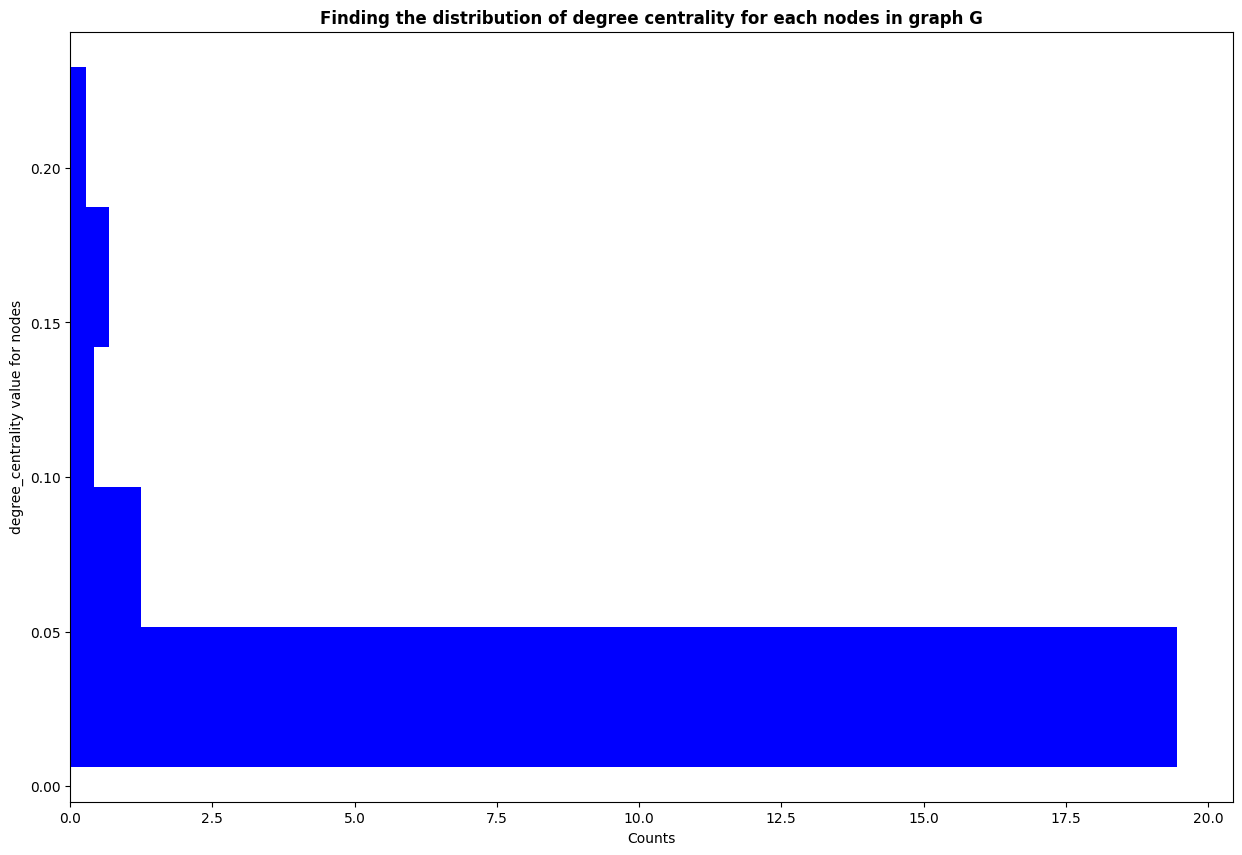

In [93]:
#plot a histogram
plt.hist(list(degree_centrality.values()),
         bins = 5,
         density = 1, 
         color ='blue',
         orientation='horizontal')

#set x and y labels
plt.xlabel('Counts')
plt.ylabel('degree_centrality value for nodes')

plt.title('Finding the distribution of degree centrality for each nodes in graph G',fontweight ="bold")

plt.show()

# Plotting graph with highlighted nodes

In [94]:
def find_nodes_with_highest_deg_cent(G, type_of_centrality='degree_centrality'):

    # Compute the degree centrality of G: deg_cent
    if(type_of_centrality=='degree_centrality'):
      deg_cent = nx.degree_centrality(G)
    elif(type_of_centrality=='closeness_centrality'):
      deg_cent = nx.closeness_centrality(G)
    elif(type_of_centrality=='betweenness_centrality'):
      deg_cent = nx.betweenness_centrality(G)
    # Compute the maximum degree centrality: max_dc
    list_of_centrality=list(sorted(deg_cent.values()))
    max_1_dc = max(list_of_centrality)
    max_2_dc = list_of_centrality[-2]
    max_3_dc = list_of_centrality[-3]

    maxnode1 = set()
    maxnode2 = set()
    maxnode3 = set()

    # Iterate over the degree centrality dictionary
    for k, v in deg_cent.items():

        # Check if the current value has the maximum degree centrality
        if v == max_1_dc:

            # Add the current node to the set of nodes
            maxnode1.add(k)
        if v == max_2_dc:

            # Add the current node to the set of nodes
            maxnode2.add(k)
        if v == max_3_dc:

            # Add the current node to the set of nodes
            maxnode3.add(k)

    return maxnode1,maxnode2,maxnode3

def plot_graph_with_highest_deg_cent(G):
  highest_deg_cent= list(find_nodes_with_highest_deg_cent(G))
  list_of_highest_deg_cent=[]
  for i in highest_deg_cent:
    list_of_highest_deg_cent.extend(list(i))
  
  color_map = []
  for node in G:
      if node in list_of_highest_deg_cent:
          color_map.append('red')
          #print("I got the node for blue",node)
      else: 
          color_map.append('blue')      
  # nx.draw(G, node_color=color_map, with_labels=True)
  # plt.show()
  pos = nx.spring_layout(G)

  _=nx.draw_networkx(G, pos,node_size=60,node_color=color_map,font_size=6) 
  #nx.draw(G,pos,node_size=60,font_size=8) 

  edge_labels=dict([((u,v,),d['relation'])
              for u,v,d in G.edges(data=True)])

  _=nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
  return

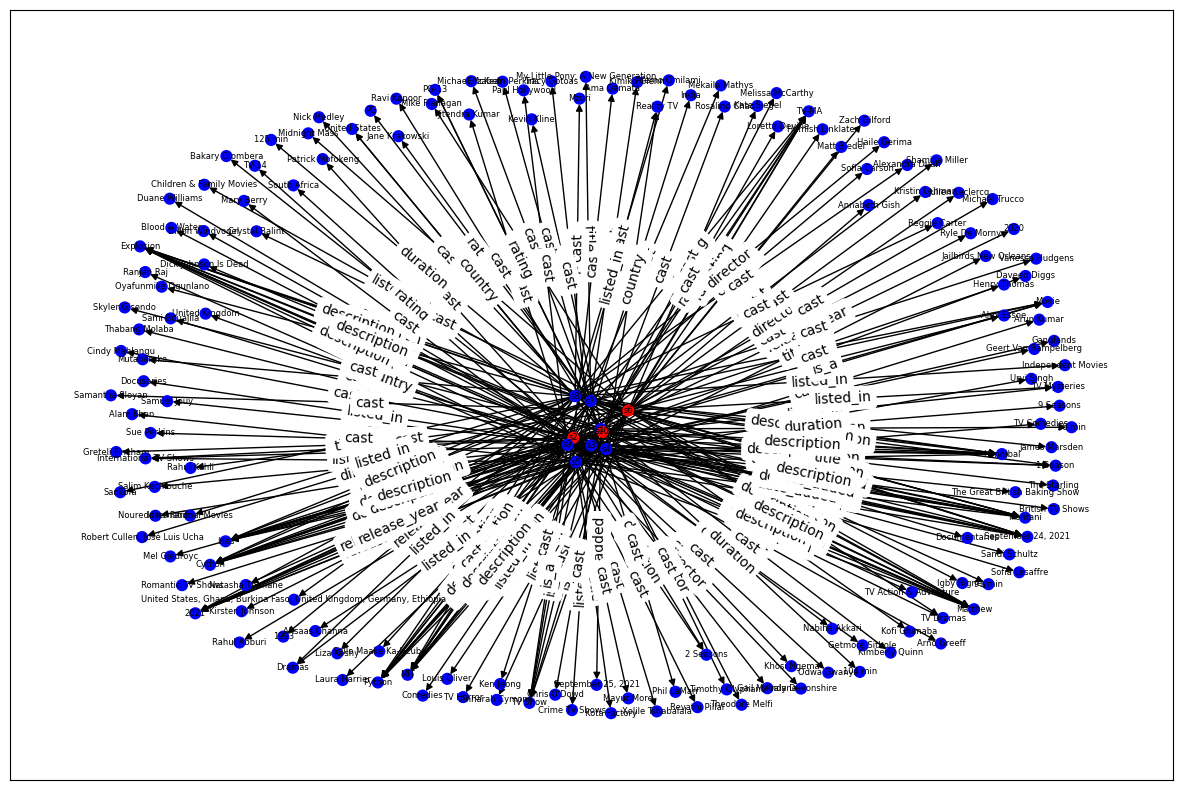

In [95]:
plot_graph_with_highest_deg_cent(G)

## Community Detection


Here due to the absence of numberical value for each node, comumunity detection couldn't be used. Thus Community Detection algorithm has ben used for Karate Club graph.

In [96]:
import networkx as nx
import networkx.algorithms.community as nxcom
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
# get reproducible results
import random
from numpy import random as nprand
random.seed(123)
nprand.seed(123)

In [97]:
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [98]:
G_karate = nx.karate_club_graph()
# Find the communities
communities = sorted(nxcom.greedy_modularity_communities(G_karate), key=len, reverse=True)
# Count the communities
print(f"The karate club has {len(communities)} communities.")
# The karate club has 3 communities.
nxcom.asyn_fluidc(G_karate,k=1)

The karate club has 3 communities.


In [99]:
# Set node and edge communities
set_node_community(G_karate, communities)
set_edge_community(G_karate)
node_color = [get_color(G_karate.nodes[v]['community']) for v in G_karate.nodes]
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in G_karate.edges if G_karate.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G_karate.edges if G_karate.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

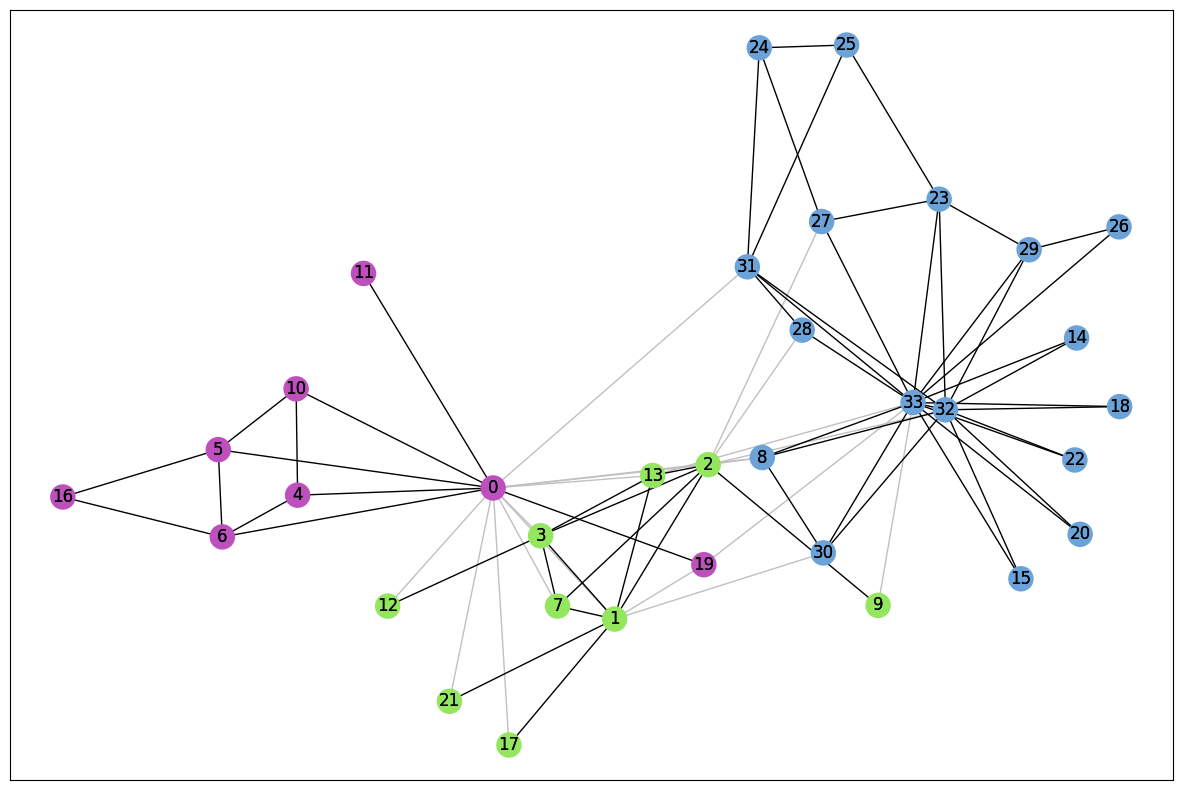

In [100]:
karate_pos = nx.spring_layout(G_karate)
plt.rcParams.update({'figure.figsize': (15, 10)})
# Draw external edges
nx.draw_networkx(
    G_karate,
    pos=karate_pos,
    node_size=0,
    edgelist=external,
    edge_color="silver")
# Draw nodes and internal edges
nx.draw_networkx(
    G_karate,
    pos=karate_pos,
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color)